# SAiDL Summer 2023 Induction Assignment

## Task 1, Core ML

### Packages -

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  2 23:55:33 2023

@author: karan_bania
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
%matplotlib inline

torch.random.manual_seed(1)
np.random.seed(1)

### Device -

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Hyper-params -

In [3]:
# Hyper-parameters 
num_epochs = 10
batch_size = 1
learning_rate = 0.001
temp = 0.9

### Pytorch Transform to normalize -

In [4]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Getting the data -

In [5]:
# CIFAR10: 60000 32x32 color images in 100 classes, with 600 images per class
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                               download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

output_iter = iter(test_loader)
features, labels = next(output_iter)
print(features, labels)
print(features.size(), labels.size())

100%|██████████| 169001437/169001437 [00:02<00:00, 66958053.95it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
tensor([[[[ 0.5608,  0.5373,  0.5294,  ...,  0.6941,  0.7020,  0.7569],
          [ 0.5451,  0.5294,  0.5294,  ...,  0.8118,  0.8275,  0.8902],
          [ 0.7412,  0.6706,  0.6392,  ...,  0.9059,  0.9137,  0.9608],
          ...,
          [-0.4353, -0.4431, -0.4196,  ...,  0.7255,  0.4353,  0.2157],
          [-0.4353, -0.4039, -0.3412,  ...,  0.7412,  0.4667,  0.1373],
          [-0.3725, -0.3412, -0.3333,  ...,  0.7020,  0.6235,  0.3804]],

         [[ 0.6863,  0.6549,  0.6471,  ...,  0.8118,  0.8118,  0.8353],
          [ 0.6471,  0.6314,  0.6471,  ...,  0.9059,  0.9059,  0.9216],
          [ 0.7725,  0.7255,  0.7176,  ...,  0.9608,  0.9529,  0.9608],
          ...,
          [-0.4275, -0.4196, -0.3882,  ...,  0.6314,  0.3176,  0.1059],
          [-0.4118, -0.3647, -0.3020,  ...,  0.6627,  0.3647,  0.0353],
          [-0.3333, -0.2941, -0.2784,  ...,  0.6235,  0.5216,  0.2863]],

         [[ 

### Example Image(s) -

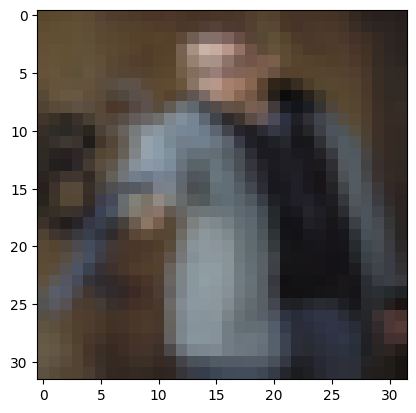

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## CNN with usual softmax -

In [7]:
class NormalConvNet(nn.Module):
    def __init__(self):
        super(NormalConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.conv2 = nn.Conv2d(6, 8, 3, padding = 1)
        self.conv3 = nn.Conv2d(8, 10, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*10, 200)
        self.fc2 = nn.Linear(200, 100)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 16, 16
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 8, 8, 8
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 10, 4, 4
        x = torch.flatten(x, start_dim = 1)   # -> n, 160
        x = F.relu(self.fc1(x))               # -> n, 200
        x = F.relu(self.fc2(x))               # -> n, 100
        return x


model = NormalConvNet().to(device)

### Loss + Optimizer -

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Training pt.1 -

In [9]:
loss_hist_N = []
iter_no_N = []
n_total_steps = len(train_loader)
times = []
current = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % (n_total_steps/5) == 0:
            loss_hist_N.append(loss.item())
            iter_no_N.append(i + epoch*n_total_steps)

        if (i+1) % (n_total_steps/10) == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    times.append(time.time() - current)
    current = time.time()
        
avg_time_N = sum(times)/len(times)

print('Finished Training')

Epoch [1/10], Step [5000/50000], Loss: 4.6224
Epoch [1/10], Step [10000/50000], Loss: 4.6217
Epoch [1/10], Step [15000/50000], Loss: 4.6026
Epoch [1/10], Step [20000/50000], Loss: 4.6214
Epoch [1/10], Step [25000/50000], Loss: 4.6248
Epoch [1/10], Step [30000/50000], Loss: 4.5470
Epoch [1/10], Step [35000/50000], Loss: 4.6216
Epoch [1/10], Step [40000/50000], Loss: 4.3718
Epoch [1/10], Step [45000/50000], Loss: 4.6281
Epoch [1/10], Step [50000/50000], Loss: 4.6411
Epoch [2/10], Step [5000/50000], Loss: 4.5409
Epoch [2/10], Step [10000/50000], Loss: 5.1629
Epoch [2/10], Step [15000/50000], Loss: 4.9461
Epoch [2/10], Step [20000/50000], Loss: 4.1057
Epoch [2/10], Step [25000/50000], Loss: 4.9588
Epoch [2/10], Step [30000/50000], Loss: 4.4596
Epoch [2/10], Step [35000/50000], Loss: 3.4971
Epoch [2/10], Step [40000/50000], Loss: 3.9367
Epoch [2/10], Step [45000/50000], Loss: 1.4580
Epoch [2/10], Step [50000/50000], Loss: 4.1784
Epoch [3/10], Step [5000/50000], Loss: 4.4158
Epoch [3/10], St

### Model Evaluation -

Accuracy of the network: 28.27 %


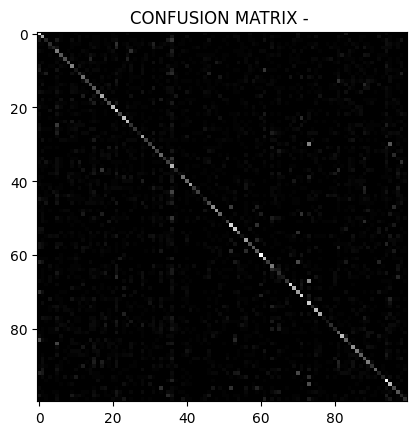

[[69.  3.  1. ...  0.  0.  0.]
 [ 6. 48.  0. ...  0.  0.  0.]
 [ 7.  0. 10. ...  1.  5.  0.]
 ...
 [ 0.  1.  0. ... 24.  2.  0.]
 [ 5.  1.  1. ...  1. 10.  3.]
 [ 0.  0.  1. ...  1.  1. 14.]]
max precision at class - 82 = 64.28571428571429%


In [10]:
with torch.no_grad():
    confusion_matrix_normal = np.zeros((100, 100))
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        for i in range(batch_size):
            confusion_matrix_normal[labels[i]][predicted[i]] += 1
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    plt.imshow(confusion_matrix_normal, cmap = 'gray')
    plt.title('CONFUSION MATRIX - ')
    plt.show()
    
    print(confusion_matrix_normal)
    
    precision = np.zeros((100,))
    recall = np.zeros((100,))
    
    for classes in range(100):
        if(np.sum(confusion_matrix_normal[:,classes]) > 0):
            precision[classes] = confusion_matrix_normal[classes][classes]/np.sum(confusion_matrix_normal[:,classes])
        else:
            precision[classes] = 0
        if(np.sum(confusion_matrix_normal[classes,:]) > 0):    
            recall[classes] = confusion_matrix_normal[classes][classes]/np.sum(confusion_matrix_normal[classes,:])
        else:
            recall[classes] = 0
    
    max_p = precision[np.argmax(precision)]
    
    print(f'max precision at class - {np.argmax(precision)} = {max_p*100}%')

## Gumbel SoftMax -

In [11]:
def gumbel_sample(shape, eps = 1e-8):
    
    U = torch.rand(shape)
    U = U.to(device)
    return -torch.log(-torch.log(U + eps) + eps)

#def gumbel_softmax(logits, temp):
#    
#    y_hat = logits + gumbel_sample(logits.size())
#    y_hat = F.softmax(y_hat/temp, dim = -1)
#    return y_hat

class loss_gumbel(nn.Module):
    
    def __init__(self):
        super(loss_gumbel, self).__init__()
    
    def forward(self, output, target, temp):
        
        criterion = nn.CrossEntropyLoss()
        y_hat = output + gumbel_sample(output.size())
        loss = criterion(y_hat/temp, target)
        
        return loss

### Same Architecture - 

In [12]:
class GumbelConvNet(nn.Module):
    def __init__(self, temp):
        super(GumbelConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.conv2 = nn.Conv2d(6, 8, 3, padding = 1)
        self.conv3 = nn.Conv2d(8, 10, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*10, 200)
        self.fc2 = nn.Linear(200, 100)
    
    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 16, 16
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 8, 8, 8
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 10, 4, 4
        x = torch.flatten(x, start_dim = 1)   # -> n, 160
        x = F.relu(self.fc1(x))               # -> n, 200
        xout = F.relu(self.fc2(x))            # -> n, 100
        
        return xout
     
G_model = GumbelConvNet(temp).to(device)

### Custom loss -

In [13]:
G_criterion = loss_gumbel()
G_optimizer = torch.optim.SGD(G_model.parameters(), lr=learning_rate)

### Training pt.2 -

In [14]:
loss_hist_G = []
iter_no_G = []
n_total_steps = len(train_loader)
times = []
current = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = G_model(images)
        #print(outputs.shape)
        #print(outputs.size(), labels.size())
        loss = G_criterion(outputs, labels, temp)

        # Backward and optimize
        G_optimizer.zero_grad()
        loss.backward()
        G_optimizer.step()
        
        if (i + 1) % (n_total_steps/5) == 0:
            loss_hist_G.append(loss.item())
            iter_no_G.append(i + epoch*n_total_steps)

        if (i + 1) % (n_total_steps/10) == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    times.append(time.time() - current)
    current = time.time()
        
avg_time_G = sum(times)/len(times)

print('Finished Training')

Epoch [1/10], Step [5000/50000], Loss: 6.4855
Epoch [1/10], Step [10000/50000], Loss: 6.2289
Epoch [1/10], Step [15000/50000], Loss: 3.3894
Epoch [1/10], Step [20000/50000], Loss: 6.5428
Epoch [1/10], Step [25000/50000], Loss: 7.1415
Epoch [1/10], Step [30000/50000], Loss: 6.9129
Epoch [1/10], Step [35000/50000], Loss: 5.7227
Epoch [1/10], Step [40000/50000], Loss: 7.5939
Epoch [1/10], Step [45000/50000], Loss: 6.8072
Epoch [1/10], Step [50000/50000], Loss: 6.4720
Epoch [2/10], Step [5000/50000], Loss: 4.0227
Epoch [2/10], Step [10000/50000], Loss: 4.8792
Epoch [2/10], Step [15000/50000], Loss: 4.9700
Epoch [2/10], Step [20000/50000], Loss: 4.5817
Epoch [2/10], Step [25000/50000], Loss: 2.9759
Epoch [2/10], Step [30000/50000], Loss: 3.8977
Epoch [2/10], Step [35000/50000], Loss: 5.0440
Epoch [2/10], Step [40000/50000], Loss: 1.7351
Epoch [2/10], Step [45000/50000], Loss: 4.6515
Epoch [2/10], Step [50000/50000], Loss: 4.8243
Epoch [3/10], Step [5000/50000], Loss: 2.9477
Epoch [3/10], St

### Model Evaluation -

Accuracy of the network: 27.4 %


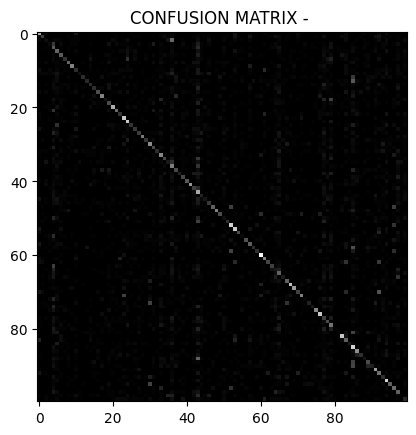

[[57.  0.  3. ...  0.  0.  0.]
 [ 4. 20.  0. ...  1.  0.  0.]
 [ 3.  0.  4. ...  1.  0.  3.]
 ...
 [ 0.  0.  0. ... 31.  0.  0.]
 [ 1.  0.  1. ...  2.  1.  1.]
 [ 0.  0.  2. ...  1.  0. 13.]]
max precision at class - 41 = 82.75862068965517%


In [15]:
with torch.no_grad():
    confusion_matrix_gumbel = np.zeros((100, 100))
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = G_model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        for i in range(batch_size):
            confusion_matrix_gumbel[labels[i]][predicted[i]] += 1
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    plt.imshow(confusion_matrix_gumbel, cmap = 'gray')
    plt.title('CONFUSION MATRIX - ')
    plt.show()
    
    print(confusion_matrix_gumbel)
    
    precision = np.zeros((100,))
    recall = np.zeros((100,))
    
    for classes in range(100):
        if(np.sum(confusion_matrix_gumbel[:,classes]) > 0):
            precision[classes] = confusion_matrix_gumbel[classes][classes]/np.sum(confusion_matrix_gumbel[:,classes])
        else:
            precision[classes] = 0
        if(np.sum(confusion_matrix_gumbel[classes,:]) > 0):    
            recall[classes] = confusion_matrix_gumbel[classes][classes]/np.sum(confusion_matrix_gumbel[classes,:])
        else:
            recall[classes] = 0
    
    max_p = precision[np.argmax(precision)]
    
    print(f'max precision at class - {np.argmax(precision)} = {max_p*100}%')

## Hierarchical SoftMax -

In [16]:
class Node:
    count_nodes = 0
    def __init__(self, label=None, parent=None, grad=True, tree=None):
        Node.count_nodes += 1
        self.label = label
        self.parent = parent
        self.left = None
        self.right = None
        self.probs = torch.normal(0, 1, size = ((100, )))
        self.probs.requires_grad_(grad)
        if(label==None and tree!=None):
            tree.append(self.probs)


def buildBinaryTree(labels, root, tree):
    if len(labels) == 1:
        return Node(labels[0], parent=root, grad=False)
    else:
        split_idx = len(labels) // 2
        left_labels, right_labels = [], []
        for i, label in enumerate(labels):
            if i < split_idx:
                left_labels.append(label)
            else:
                right_labels.append(label)
        node = Node(parent=root, tree=tree)
        node.left = buildBinaryTree(left_labels, root=node, tree=tree)
        node.right = buildBinaryTree(right_labels, root=node, tree=tree)
        return node

# Build a binary tree using CIFAR-100 dataset
labels = [i for i in range(100)]
tree = []
root = buildBinaryTree(labels, None, tree)

### Printing leaf nodes of the tree -

In [17]:
node_temp = root
visited = [False for i in range(100)]
label_node = {}
print("leaf nodes -")
def print_tree(root):
    if(root != None):
        if(root.left != None):
            if(root.left.label != None and visited[root.left.label] == False):
                #tree.append(root.left)
                visited[root.left.label] = True
                print(root.left.label, end = " ")
                label_node[root.left.label] = root.left
            print_tree(root.left)

    if(root.right != None):
        if(root.right.label != None and visited[root.right.label] == False):
            #tree.append(root.right)
            visited[root.right.label] = True
            print(root.right.label, end = " ")
            label_node[root.right.label] = root.right
        print_tree(root.right)

    #else:
    #    print("hit the boottom")

print_tree(node_temp)

leaf nodes -
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

### Calculating the paths to be traversed from the root to the Leaf for a particular label -

In [18]:
paths = {}
for label in range(100):
    paths[label] = []
    base_node = label_node[label]
    while base_node.parent != root :
        paths[label].append(base_node.parent)
        base_node = base_node.parent
    paths[label].append(base_node.parent)

#print(paths[71])
#print(len(paths[71]))

### Same Base Architecture but the forward pass accomodates for Hierarchical SoftMax -

In [19]:
class HierarchicalConvNet(nn.Module):
    def __init__(self):
        super(HierarchicalConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.conv2 = nn.Conv2d(6, 8, 3, padding = 1)
        self.conv3 = nn.Conv2d(8, 10, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*10, 200)
        self.fc2 = nn.Linear(200, 100)
    
    def forward(self, x, paths=None, mode='train'):
        # -> n, 3, 32, 32
        batch_size = x.shape[0]
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 16, 16
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 8, 8, 8
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 10, 4, 4
        x = torch.flatten(x, start_dim = 1)   # -> n, 160
        x = F.relu(self.fc1(x))               # -> n, 200
        x = F.relu(self.fc2(x))               # -> n, 100

        #return x

        if(mode == 'train'):
            probs = []
            for example in range(batch_size):
                prob = [1]
                path = paths[example]
                length = len(path)
                for j in range(length - 1, 0, -1): #reverse traversal
                    curr_node = path[j]
                    w = curr_node.probs
                    if(curr_node.left == path[j - 1]):
                        prob.append(prob[-1]*torch.sigmoid(torch.dot(x[example], w)))
                    else:
                        prob.append(prob[-1]*(1 - torch.sigmoid(torch.dot(x[example], w)))) #torch.reshape(
                probs.append(prob[-1])
             
            return torch.stack(probs) #torch.reshape(probs, (1,))

        else:
            with torch.no_grad():
                predictions = []
                for example in range(batch_size):
                    temp_node = root
                    while not(temp_node.left==None and temp_node.right==None):
                        temp = torch.sigmoid(torch.dot(x[example], temp_node.probs))
                        if(temp.item() > 0.5):
                            temp_node = temp_node.left
                        else:
                            temp_node = temp_node.right
                    predictions.append(temp_node.label)

            return predictions

H_model = HierarchicalConvNet().to(device)

### Now we have two distinct sets of parameters to optimize - 

In [20]:
H_criterion = torch.nn.BCELoss() 
H_optimizer1 = torch.optim.SGD(H_model.parameters(), lr=learning_rate)
H_optimizer2 = torch.optim.SGD([probs for probs in tree], lr=learning_rate)

### Training pt.3 -

In [21]:
n_total_steps = len(train_loader)
loss_hist_H = []
iter_no_H = []
num_epochs = 30
times = []
current = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = H_model(images, [paths[label.item()] for label in labels])
        ground_op = torch.ones_like(labels, dtype = torch.float32)
        loss = H_criterion(outputs, ground_op)

        # Backward and optimize
        loss.backward()
        H_optimizer1.step()
        H_optimizer2.step()
        #if(i < 100):
        #  print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{n_total_steps}], Loss: {loss.item():.4f}')

        H_optimizer1.zero_grad()
        H_optimizer2.zero_grad()

        if (i + 1)%(n_total_steps/5) == 0:
            loss_hist_H.append(loss.item())
            iter_no_H.append(i + epoch*n_total_steps)

        if i%(n_total_steps/10) == 0: #i < 5000 or 
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    times.append(time.time() - current)
    current = time.time()
        
avg_time_H = sum(times)/len(times)

print('Finished Training')

Epoch [1/30], Step [0/50000], Loss: 3.5227
Epoch [1/30], Step [5000/50000], Loss: 3.9806
Epoch [1/30], Step [10000/50000], Loss: 3.6323
Epoch [1/30], Step [15000/50000], Loss: 3.9361
Epoch [1/30], Step [20000/50000], Loss: 1.4274
Epoch [1/30], Step [25000/50000], Loss: 2.4946
Epoch [1/30], Step [30000/50000], Loss: 3.5983
Epoch [1/30], Step [35000/50000], Loss: 3.1524
Epoch [1/30], Step [40000/50000], Loss: 3.9554
Epoch [1/30], Step [45000/50000], Loss: 3.3815
Epoch [2/30], Step [0/50000], Loss: 4.0832
Epoch [2/30], Step [5000/50000], Loss: 3.1765
Epoch [2/30], Step [10000/50000], Loss: 3.7823
Epoch [2/30], Step [15000/50000], Loss: 2.0767
Epoch [2/30], Step [20000/50000], Loss: 3.2926
Epoch [2/30], Step [25000/50000], Loss: 3.8424
Epoch [2/30], Step [30000/50000], Loss: 2.3470
Epoch [2/30], Step [35000/50000], Loss: 4.7137
Epoch [2/30], Step [40000/50000], Loss: 4.3189
Epoch [2/30], Step [45000/50000], Loss: 3.9706
Epoch [3/30], Step [0/50000], Loss: 5.0160
Epoch [3/30], Step [5000/50

### Model Evaluation -

Accuracy of the network: 8.92 %


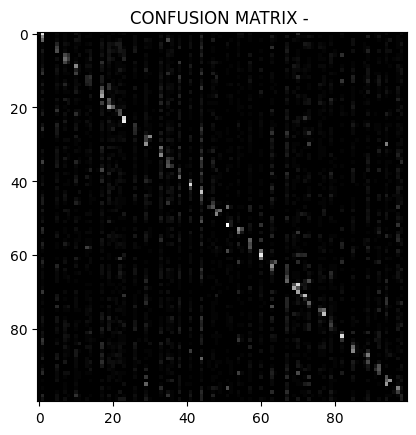

[[ 3. 51.  0. ...  0.  2.  0.]
 [ 0. 31.  0. ...  1.  0.  0.]
 [ 0. 22.  0. ...  1.  1.  0.]
 ...
 [ 0.  0.  0. ... 14.  2.  0.]
 [ 0.  8.  0. ...  2.  8.  0.]
 [ 0.  4.  0. ...  0.  7.  0.]]
max precision at class - 0 = 100.0%


In [22]:
with torch.no_grad():
    confusion_matrix_hierarchical = np.zeros((100, 100))
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        outputs = H_model(images, mode='test')
        batch_size = labels.shape[0]
        for i in range(batch_size):
            if(outputs[i] == labels[i]):
                n_correct += 1
            confusion_matrix_hierarchical[labels[i]][outputs[i]] += 1
        n_samples += labels.shape[0]

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    plt.imshow(confusion_matrix_hierarchical, cmap = 'gray')
    plt.title('CONFUSION MATRIX - ')
    plt.show()
    
    print(confusion_matrix_hierarchical)
    
    precision = np.zeros((100,))
    recall = np.zeros((100,))
    
    for classes in range(100):
        if(np.sum(confusion_matrix_hierarchical[:,classes]) > 0):
            precision[classes] = confusion_matrix_hierarchical[classes][classes]/np.sum(confusion_matrix_hierarchical[:,classes])
        else:
            precision[classes] = 0
        if(np.sum(confusion_matrix_hierarchical[classes,:]) > 0):    
            recall[classes] = confusion_matrix_hierarchical[classes][classes]/np.sum(confusion_matrix_hierarchical[classes,:])
        else:
            recall[classes] = 0
    
    max_p = precision[np.argmax(precision)]
    
    print(f'max precision at class - {np.argmax(precision)} = {max_p*100}%')

## Adaptive - 

In [23]:
class AdaptiveConvNet(nn.Module):
    def __init__(self):
        super(AdaptiveConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.conv2 = nn.Conv2d(6, 8, 3, padding = 1)
        self.conv3 = nn.Conv2d(8, 10, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4*4*10, 200)
        self.fc2 = nn.Linear(200, 100)
        #self.hierarchical_softmax = HierarchicalSoftmaxLinear(in_features = 100, root = root)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 16, 16
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 8, 8, 8
        x = self.pool(F.relu(self.conv3(x)))  # -> n, 10, 4, 4
        x = torch.flatten(x, start_dim = 1)   # -> n, 160
        x = F.relu(self.fc1(x))               # -> n, 200
        x = F.relu(self.fc2(x))               # -> n, 100
        #out = self.hierarchical_softmax(x)
        return x


A_model = AdaptiveConvNet().to(device)

### Using pyTorch's in-built implementation -

In [24]:
A_criterion = torch.nn.AdaptiveLogSoftmaxWithLoss(100, 100, [10, 90])
A_optimizer = torch.optim.SGD(A_model.parameters(), lr=learning_rate)
num_epochs = 10

In [25]:
n_total_steps = len(train_loader)
loss_hist_A = []
iter_no_A = []
times = []
current = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = A_model(images)
        output, loss = A_criterion(outputs, labels)

        # Backward and optimize
        A_optimizer.zero_grad()
        loss.backward()
        A_optimizer.step()
        
        if (i + 1) % (n_total_steps/5) == 0:
            loss_hist_A.append(loss.item())
            iter_no_A.append(i + epoch*epoch)

        if (i + 1) % (n_total_steps/10) == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
    times.append(time.time() - current)
    current = time.time()
        
avg_time_A = sum(times)/len(times)

print('Finished Training')

Epoch [1/10], Step [5000/50000], Loss: 4.4108
Epoch [1/10], Step [10000/50000], Loss: 4.2215
Epoch [1/10], Step [15000/50000], Loss: 4.8188
Epoch [1/10], Step [20000/50000], Loss: 4.8415
Epoch [1/10], Step [25000/50000], Loss: 4.5598
Epoch [1/10], Step [30000/50000], Loss: 4.8101
Epoch [1/10], Step [35000/50000], Loss: 4.2517
Epoch [1/10], Step [40000/50000], Loss: 4.7686
Epoch [1/10], Step [45000/50000], Loss: 4.4813
Epoch [1/10], Step [50000/50000], Loss: 4.4871
Epoch [2/10], Step [5000/50000], Loss: 3.9175
Epoch [2/10], Step [10000/50000], Loss: 4.2999
Epoch [2/10], Step [15000/50000], Loss: 4.2109
Epoch [2/10], Step [20000/50000], Loss: 4.4193
Epoch [2/10], Step [25000/50000], Loss: 4.6251
Epoch [2/10], Step [30000/50000], Loss: 4.5967
Epoch [2/10], Step [35000/50000], Loss: 4.5477
Epoch [2/10], Step [40000/50000], Loss: 4.4784
Epoch [2/10], Step [45000/50000], Loss: 4.6490
Epoch [2/10], Step [50000/50000], Loss: 4.6270
Epoch [3/10], Step [5000/50000], Loss: 4.4124
Epoch [3/10], St

Accuracy of the network: 0.83 %


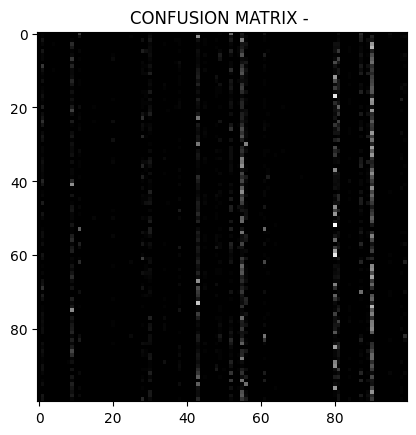

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 2.]
 [0. 6. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 7. 0. ... 0. 0. 0.]
 [0. 6. 0. ... 0. 1. 0.]]
max precision at class - 34 = 11.538461538461538%


In [26]:
with torch.no_grad():
    confusion_matrix_adaptive = np.zeros((100, 100))
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = A_model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        for i in range(batch_size):
            confusion_matrix_adaptive[labels[i]][predicted[i]] += 1
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    plt.imshow(confusion_matrix_adaptive, cmap = 'gray')
    plt.title('CONFUSION MATRIX - ')
    plt.show()
    
    print(confusion_matrix_adaptive)
    
    precision = np.zeros((100,))
    recall = np.zeros((100,))
    
    for classes in range(100):
        if(np.sum(confusion_matrix_adaptive[:,classes]) > 0):
            precision[classes] = confusion_matrix_adaptive[classes][classes]/np.sum(confusion_matrix_adaptive[:,classes])
        else:
            precision[classes] = 0
        if(np.sum(confusion_matrix_adaptive[classes,:]) > 0):    
            recall[classes] = confusion_matrix_gumbel[classes][classes]/np.sum(confusion_matrix_adaptive[classes,:])
        else:
            recall[classes] = 0
    
    max_p = precision[np.argmax(precision)]
    
    print(f'max precision at class - {np.argmax(precision)} = {max_p*100}%')

## Loss vs iteration graphs - 

### Normal Softmax - 

Text(0.5, 1.0, 'iterations vs loss - Normal')

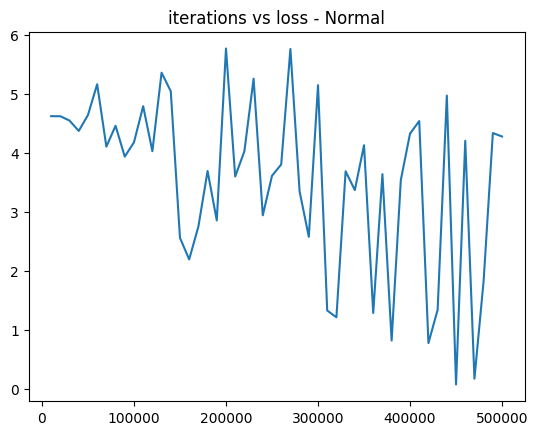

In [27]:
plt.plot(iter_no_N, loss_hist_N)
plt.title("iterations vs loss - Normal")

### Gumbel SoftMax - 

Text(0.5, 1.0, 'iterations vs loss - Gumbel')

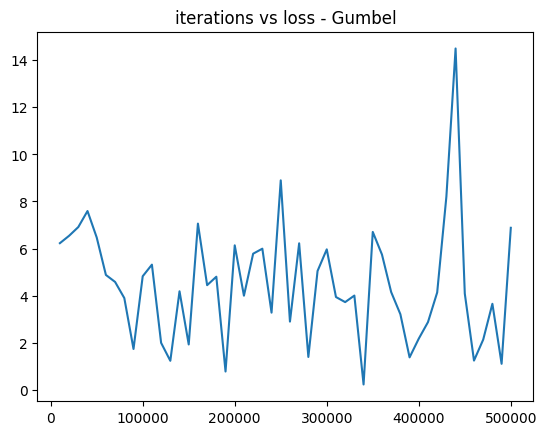

In [28]:
plt.plot(iter_no_G, loss_hist_G)
plt.title("iterations vs loss - Gumbel")

### Hierarchical SoftMax -

Text(0.5, 1.0, 'iterations vs loss - Hierarchical')

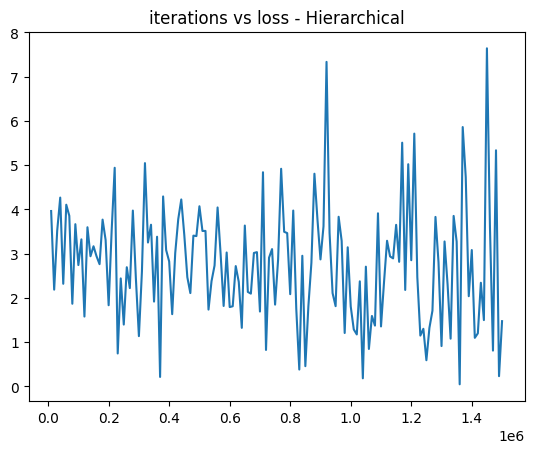

In [29]:
plt.plot(iter_no_H, loss_hist_H)
plt.title("iterations vs loss - Hierarchical")

### Adaptive SoftMax -

Text(0.5, 1.0, 'iterations vs loss - Adaptive')

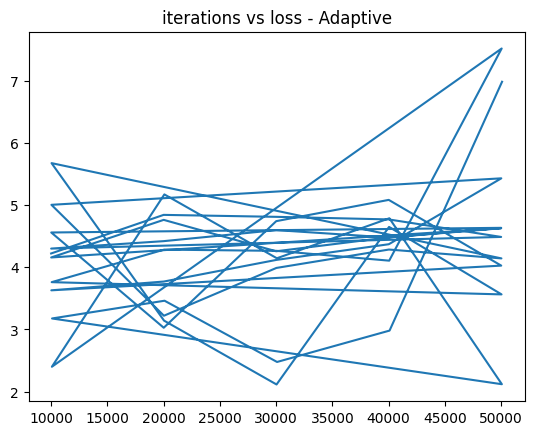

In [30]:
plt.plot(iter_no_A, loss_hist_A)
plt.title("iterations vs loss - Adaptive")

## Time per epoch -

In [31]:
print(f"With normal softmax, each epoch lasted {avg_time_N}s")
print(f"With gumbel softmax, each epoch lasted {avg_time_G}s")
print(f"With hierarchical softmax, each epoch lasted {avg_time_H}s")
print(f"With adaptive softmax, each epoch lasted {avg_time_A}s")

With normal softmax, each epoch lasted 65.34760665893555s
With gumbel softmax, each epoch lasted 72.78400754928589s
With hierarchical softmax, each epoch lasted 94.77085032463074s
With adaptive softmax, each epoch lasted 90.80197658538819s


## Model Architectures -



In [32]:
print("Architecture of Normal Model -")
print(model)
print("Architecture of Gumbel Model -")
print(G_model)
print("Architecture of Hierarchical Model -")
print(H_model)
print("Architecture of Adaptive Model -")
print(A_model)

Architecture of Normal Model -
NormalConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=160, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
)
Architecture of Gumbel Model -
GumbelConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=160, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
)
Architecture of Hierarchical Model

## Precision, Recall and F1 scores -

In [33]:
precision_N = 0.
recall_N = 0.
precision_G = 0.
recall_G = 0.
precision_H = 0.
recall_H = 0.
precision_A = 0.
recall_A = 0.


for classes in range(100):
    
    #Normal -
    if(np.sum(confusion_matrix_normal[:,classes]) > 0):
        precision_N += confusion_matrix_normal[classes][classes]/np.sum(confusion_matrix_normal[:,classes])
    if(np.sum(confusion_matrix_normal[classes,:]) > 0):    
        recall_N += confusion_matrix_normal[classes][classes]/np.sum(confusion_matrix_normal[classes,:])
        
    #Gumbel - 
    if(np.sum(confusion_matrix_normal[:,classes]) > 0):
        precision_G += confusion_matrix_gumbel[classes][classes]/np.sum(confusion_matrix_normal[:,classes])
    if(np.sum(confusion_matrix_normal[classes,:]) > 0):    
        recall_G += confusion_matrix_gumbel[classes][classes]/np.sum(confusion_matrix_normal[classes,:])
        
    #Hierarchical -
    if(np.sum(confusion_matrix_normal[:,classes]) > 0):
        precision_H += confusion_matrix_hierarchical[classes][classes]/np.sum(confusion_matrix_normal[:,classes])
    if(np.sum(confusion_matrix_normal[classes,:]) > 0):    
        recall_H += confusion_matrix_hierarchical[classes][classes]/np.sum(confusion_matrix_normal[classes,:])
        
    #Adaptive - 
    if(np.sum(confusion_matrix_normal[:,classes]) > 0):
        precision_A += confusion_matrix_adaptive[classes][classes]/np.sum(confusion_matrix_normal[:,classes])
    if(np.sum(confusion_matrix_normal[classes,:]) > 0):    
        recall_A += confusion_matrix_adaptive[classes][classes]/np.sum(confusion_matrix_normal[classes,:])

precision_N /= 100
recall_N /= 100
precision_G /= 100
recall_G /= 100
precision_H /= 100
recall_H /= 100
precision_A /= 100
recall_A /= 100
F1_N = 2/((1/precision_N) + (1/recall_N))
F1_G = 2/((1/precision_G) + (1/recall_G))
F1_H = 2/((1/precision_H) + (1/recall_H))
F1_A = 2/((1/precision_A) + (1/recall_A))

print(f"for Normal SoftMax, Precision - {precision_N:.4f}, Recall - {recall_N:.4f} and F1-score is - {F1_N:.4f}")
print(f"for Gumbel SoftMax, Precision - {precision_G:.4f}, Recall - {recall_G:.4f} and F1-score is - {F1_G:.4f}")
print(f"for Hierarchical SoftMax, Precision - {precision_H:.4f}, Recall - {recall_H:.4f} and F1-score is - {F1_H:.4f}")
print(f"for Adaptive SoftMax, Precision - {precision_A:.4f}, Recall - {recall_A:.4f} and F1-score is - {F1_A:.4f}")

for Normal SoftMax, Precision - 0.2952, Recall - 0.2827 and F1-score is - 0.2888
for Gumbel SoftMax, Precision - 0.3449, Recall - 0.2740 and F1-score is - 0.3054
for Hierarchical SoftMax, Precision - 0.1082, Recall - 0.0892 and F1-score is - 0.0978
for Adaptive SoftMax, Precision - 0.0107, Recall - 0.0083 and F1-score is - 0.0093


## Thanks!